# Extract the MS2 scan and do signature neutral loss search
- run multiple files
- need to define a precursor target list & scan range (let's just try to do more inclusive one)

In [1]:
# !pip install pymzml
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymzml
import os
import pandas as pd
import sys

In [3]:
sys.path.append('../pyutils/')  # add the second parent directory
from searchMS2 import *

In [4]:
# spectrum.selected_precursors
# [{'mz': 417.320373535156, 'charge': 1, 'precursor id': '2'}]

In [5]:
dir_path = "../../../../raw_mzML/pooled_sample_DDA/mzML/RPneg/"
files_and_dirs = os.listdir(dir_path)

# Get the full path for each file/directory in the list
infiles = [os.path.join(dir_path, file) for file in files_and_dirs]

In [6]:
exps = []
for infile in infiles:
    exps.append(pymzml.run.Reader(infile))

[Warning] Not index found and build_index_from_scratch is False


## Basic information - using the first instance

In [7]:
exp = pymzml.run.Reader(infiles[0])

[Warning] Not index found and build_index_from_scratch is False


In [8]:
# How many spectra
exp.get_spectrum_count()

6830

In [9]:
exp.ms_precisions # ms-level 1: ppm 5; ms-level 2: ppm 20?

{None: 0.0001, 0: 0.0001, 1: 5e-06, 2: 2e-05}

### Small benchmarking if needed

2594
[Warning] Not index found and build_index_from_scratch is False


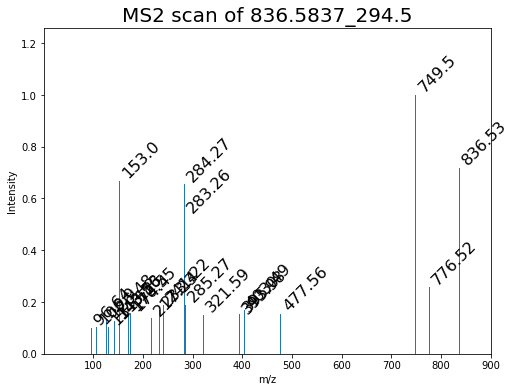

In [10]:
collect_spec = []
ii = 0 
for spec in exp:
    if spec.ms_level == 2: 
        if (2000 < ii < 3500) & (836 < spec.selected_precursors[0]['mz'] < 837):
            print(ii)
            collect_spec.append(spec)
        ii += 1

plot_spectra(collect_spec)

In [11]:
search_NL(collect_spec,
              NL_mz = 87.03124,
              ppm = 100)

-0.0009055273437468259
10.404624175719269


[<__main__.Spectrum object with native ID 2874 at 0x7fe8a24307f0>]

##### summary
- a probably 12 min run (720 secs) for 4008 scans
- 0.17964 second/scan

## Load target list

In [12]:
df_sel = pd.read_csv("./data/input/features_matched2targetPS_M-Honly.csv")

In [13]:
df_sel.head(10)

,FTID,formula,neutral_mass,short_name
0,F9996,C43H76NO10P,797.520687,PS 37:4
1,F9994,C43H76NO10P,797.520687,PS 37:4
2,F9995,C43H76NO10P,797.520687,PS 37:4
3,F9997,C43H76NO10P,797.520687,PS 37:4
4,F14243,C49H84NO10P,877.583287,PS 43:6
5,F14242,C49H84NO10P,877.583287,PS 43:6
6,F5440,C26H50NO10P,567.317237,PS 20:0
7,F5441,C26H50NO10P,567.317237,PS 20:0
8,F13352,C42H80NO10P,789.551987,PS 36:1
9,F13353,C42H80NO10P,789.551987,PS 36:1


In [14]:
FTIDs = df_sel['FTID'].tolist()

In [15]:
df_feat_annot = pd.read_csv("../../../../asari-output-RPneg/output_asari_project_31312361/Feature_annotation.tsv",
                           sep = '\t', index_col=0)

In [16]:
# Select the desired rows and columns from the DataFrame
subset = df_feat_annot.loc[FTIDs, ['mz', 'rtime', 'apex(scan number)']]
# drop duplicates
subset_dd = subset.drop_duplicates() 
# Convert the subset to a dictionary with row-wise orientation
target_dict = subset_dd.to_dict(orient='index')

In [17]:
list(target_dict.items())[0]

('F9996', {'mz': 796.5134125, 'rtime': 247.5722656, 'apex(scan number)': 1119})

## Do a pre-filtering, mostly those that fall outside rtime 200-400 seconds, probably won't be PS

In [18]:
target_dict_upd = {}
for k,v in target_dict.items():
    if 200<v['rtime']<450:
        target_dict_upd.update({k:v})

In [19]:
len(target_dict)

262

In [20]:
len(target_dict_upd)

209

In [21]:
# testing
target_dict_test = {k:v for k,v in target_dict_upd.items() if k == "F13804"}
target_dict_test

{'F13804': {'mz': 836.5431061,
  'rtime': 308.9440999,
  'apex(scan number)': 1411}}

## get potential precursor from multiple files

In [ ]:
res_dict = {}
for exp in exps:
    for k,v in target_dict_upd.items(): # target_dict_test target_dict_upd
        spectra = get_potential_precursor_from_exp_filtbyRt(exp, 
                              min_rt_sec = v['rtime']-100, 
                              max_rt_sec = v['rtime']+100, 
                              min_mz = v['mz']-1, 
                              max_mz = v['mz']+1, 
                              ms_level=2)
        res_dict[k] = spectra

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_inde

In [ ]:
res_dict_clean = {k:v for k,v in res_dict.items() if len(v) != 0}

In [ ]:
NL_res_dict = {}
for FTID, spectra in res_dict_clean.items():
    NL_res_dict.update({FTID: search_NL(spectra)})

In [ ]:
NL_res_dict_clean = {k:v for k,v in NL_res_dict.items() if len(v) != 0}

In [ ]:
NL_res_dict_clean

# plot accordingly

In [ ]:
NL_res_dict_clean.keys()

In [ ]:
df_sel.index = df_sel['FTID']

In [ ]:
df_sel.columns[0:6]

In [ ]:
for FTID in NL_res_dict_clean.keys():
    plot_spectra(spectra = NL_res_dict_clean[FTID], 
                 save_figure=True,
                 output_path=f"./data/output_pooled_samples_regDDA/{FTID}_{df_sel.loc[FTID,'short_name']}/",
                 label = f"{FTID}_{df_sel.loc[FTID,'short_name']}"
                 )